### Imports and data reading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns

In [2]:
training_data = pd.read_csv("../training data.csv")
training_data.head()

,PDB codes,VDWAALS 1,EEL 1,EGB 1,ESURF 1,GGAS 1,GSOLV 1,TOTAL 1,hbdist_mean1,hbdist_std1,...,GGAS 2,GSOLV 2,TOTAL 2,hbdist_mean2,hbdist_std2,hbnum_mean2,hbnum_std2,hbnum_mean_<.35_2,hbnum_std_<.35_2,Output
0,"4hj8 , 2la5",2.857144,6.346850,15.364635,2.727722,14.530470,15.364635,-113.49,-720.46,739.96,...,20.680320,18.000000,-89.04,-3797.32,3785.39,-12.50,-3886.36,3772.90,-113.46,0
1,"1osb , 2mki",2.857144,6.319618,87.585415,4.537219,65.985015,87.585415,-563.32,-11193.39,11154.77,...,11.741259,6.296703,-85.56,-260.76,305.67,-10.57,-346.32,295.11,-51.21,1
2,"5wzj , 1je8",2.857143,5.946841,31.663337,2.959525,40.330669,31.663337,-230.34,130.79,-82.34,...,26.929071,49.412587,-309.02,-25367.65,25386.51,-44.66,-25676.67,25341.85,-334.82,0
3,"3moj , 1wwd",2.857143,6.500905,13.814186,2.719199,18.559441,13.814186,-118.26,-7867.57,7908.33,...,9.180819,9.595405,-69.90,-995.71,1011.87,-8.73,-1065.60,1003.13,-62.47,1
4,"3rn2 , 2kx5",2.857141,7.035113,16.630370,2.416485,7.082917,16.630370,-79.85,-13297.79,13326.09,...,20.099900,13.930070,-90.79,-5001.44,5006.58,-12.27,-5092.23,4994.32,-97.91,0


### Useful functions

In [3]:
def cross_val(model, x, y, cv = 5, fit_params = None):
    """
    It prints the mean of cross_val_score

    """
    from sklearn.model_selection import cross_val_score
    print(type(model))
    score = cross_val_score(model, x, y, cv = cv, n_jobs = -1, fit_params = fit_params)
    print(score)
    print("mean of cross val score:")
    print(np.mean(score))
    print()
    print()

def simple_test(model, x, y):
    """
    For a model already trained
    """

    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    from sklearn.metrics import confusion_matrix


    y_pred = model.predict(x)

    print("--------------results-----------------------------")
    print("accuracy\t", accuracy_score(y, y_pred))
    print("f1 score\t", f1_score(y, y_pred))
    print("precision\t", precision_score(y, y_pred))
    print("recall\t\t", recall_score(y, y_pred))
    print("confusion matrix:\n", confusion_matrix(y, y_pred))
    print()

### Scaling the data

In [4]:
scaler = MinMaxScaler()
scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data.iloc[:,1:-1]))
scaled_training_data['Output'] = training_data.iloc[:,-1]
scaled_training_data.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Output
0,0.734848,0.567790,0.138163,0.411012,0.142672,0.138163,0.846356,0.681347,0.317074,0.865515,...,0.219425,0.165335,0.892359,0.618696,0.379217,0.881016,0.623812,0.379884,0.881157,0
1,0.738889,0.550689,0.882776,0.867288,0.784851,0.882776,0.000000,0.468095,0.529590,0.000000,...,0.107861,0.044671,0.898907,0.690708,0.308213,0.909507,0.696039,0.308928,0.964703,1
2,0.680808,0.316596,0.306207,0.469462,0.464672,0.306207,0.626503,0.698681,0.300295,0.647919,...,0.297413,0.489206,0.478466,0.179476,0.819991,0.406259,0.179227,0.819946,0.584069,0
3,0.665657,0.664532,0.122178,0.408863,0.192956,0.122178,0.837382,0.535816,0.463346,0.835105,...,0.075905,0.078681,0.928371,0.675743,0.322623,0.936670,0.681364,0.323373,0.949591,1
4,0.328788,1.000000,0.151213,0.332531,0.049723,0.151213,0.909650,0.425245,0.573896,0.849572,...,0.212181,0.123373,0.889067,0.594177,0.404135,0.884411,0.599209,0.404804,0.902027,0


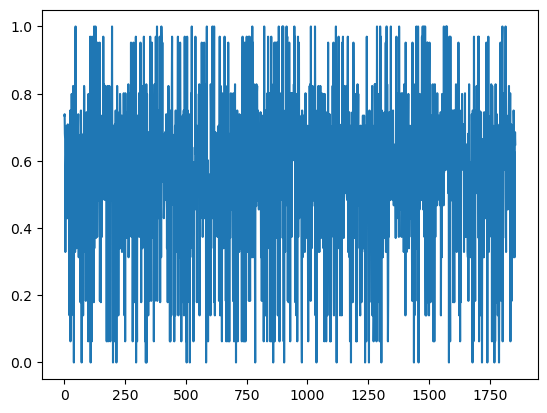

In [5]:
plt.plot(range(len(scaled_training_data)), scaled_training_data.iloc[:,0])
plt.show()

### Analysis of features

In [6]:
# Calculate p-values using ANOVA
_, p_values_anova = f_oneway(scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 1], scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 0])

# Calculate p-values using t-test (idea is similar to ANOVA, could also be exluded)
_, p_values_ttest = ttest_ind(scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 1], scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 0])

# Combine p-values (if desired)
# Using minimum p-value as a combination method
p_values_combined = np.minimum(p_values_anova, p_values_ttest)
print('p_values:', np.sort(p_values_combined))
print()

# Sort features based on p-values
sorted_features = np.argsort(p_values_combined)
print('Features in order of statistical significance:\n', training_data.columns[sorted_features+1])

p_values: [1.87379840e-20 2.74256506e-20 2.78856639e-20 2.92797218e-20
 7.58766706e-20 1.07012167e-19 1.08510365e-19 1.11830050e-19
 7.14261427e-11 8.65570640e-10 4.27424949e-08 5.95304522e-08
 3.47348395e-07 5.37653730e-07 5.71579143e-07 7.25320466e-07
 2.63081180e-05 3.32922989e-05 3.32922989e-05 9.36062854e-05
 1.47453799e-04 1.96614933e-04 3.18383556e-04 3.18383556e-04
 2.70282952e-01 4.48029726e-01]

Features in order of statistical significance:
 Index(['hbnum_std2', 'hbdist_mean2', 'hbdist_std2', 'hbnum_mean_<.35_2',
       'hbnum_std1', 'hbdist_std1', 'hbdist_mean1', 'hbnum_mean_<.35_1',
       'ESURF 2', 'ESURF 1', 'hbnum_mean2', 'hbnum_mean1', 'hbnum_std_<.35_2',
       'TOTAL 2', 'TOTAL 1', 'hbnum_std_<.35_1', 'EEL 1', 'GSOLV 2', 'EGB 2',
       'EEL 2', 'GGAS 2', 'GGAS 1', 'GSOLV 1', 'EGB 1', 'VDWAALS 1',
       'VDWAALS 2'],
      dtype='object')


### Naive Bayes

In [7]:
X_train, y_train = scaled_training_data.iloc[:,:-1], scaled_training_data.iloc[:,-1]
X_train.columns = ['VDWAALS 1', 'EEL 1', 'EGB 1', 'ESURF 1', 'GGAS 1',
       'GSOLV 1', 'TOTAL 1', 'hbdist_mean1', 'hbdist_std1', 'hbnum_mean1',
       'hbnum_std1', 'hbnum_mean_<.35_1', 'hbnum_std_<.35_1', 'VDWAALS 2',
       'EEL 2', 'EGB 2', 'ESURF 2', 'GGAS 2', 'GSOLV 2', 'TOTAL 2',
       'hbdist_mean2', 'hbdist_std2', 'hbnum_mean2', 'hbnum_std2',
       'hbnum_mean_<.35_2', 'hbnum_std_<.35_2']

In [8]:
gnb = GaussianNB()
cross_val(gnb, X_train, y_train)

<class 'sklearn.naive_bayes.GaussianNB'>
[0.62096774 0.61455526 0.60377358 0.606469   0.56334232]
mean of cross val score:
0.6018215807321103




In [9]:
cnb = ComplementNB()
cross_val(cnb, X_train, y_train)

<class 'sklearn.naive_bayes.ComplementNB'>
[0.65053763 0.606469   0.66576819 0.60916442 0.60916442]
mean of cross val score:
0.6282207344288903




### Quadratic Discriminant Analysis

In [10]:
qda = QuadraticDiscriminantAnalysis()
cross_val(qda, X_train, y_train)

<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
[0.68548387 0.59838275 0.5606469  0.74932615 0.73584906]
mean of cross val score:
0.6659377445439527




### Dropping features resulted non-significant

In [12]:
training_data.columns

Index(['PDB codes', 'VDWAALS 1', 'EEL 1', 'EGB 1', 'ESURF 1', 'GGAS 1',
       'GSOLV 1', 'TOTAL 1', 'hbdist_mean1', 'hbdist_std1', 'hbnum_mean1',
       'hbnum_std1', 'hbnum_mean_<.35_1', 'hbnum_std_<.35_1', 'VDWAALS 2',
       'EEL 2', 'EGB 2', 'ESURF 2', 'GGAS 2', 'GSOLV 2', 'TOTAL 2',
       'hbdist_mean2', 'hbdist_std2', 'hbnum_mean2', 'hbnum_std2',
       'hbnum_mean_<.35_2', 'hbnum_std_<.35_2', 'Output'],
      dtype='object')

In [13]:
significant_training_data = training_data[['EEL 1', 'EGB 1', 'ESURF 1', 'GGAS 1',
       'GSOLV 1', 'TOTAL 1', 'hbdist_mean1', 'hbdist_std1', 'hbnum_mean1',
       'hbnum_std1', 'hbnum_mean_<.35_1', 'hbnum_std_<.35_1',
       'EEL 2', 'EGB 2', 'ESURF 2', 'GGAS 2', 'GSOLV 2', 'TOTAL 2',
       'hbdist_mean2', 'hbdist_std2', 'hbnum_mean2', 'hbnum_std2',
       'hbnum_mean_<.35_2', 'hbnum_std_<.35_2', 'Output']]

In [14]:
significant_training_data.to_csv("ANOVAsignificant_trainingdata.csv",index=False)

In [15]:
scaled_significant_training_data = pd.DataFrame(scaler.fit_transform(significant_training_data.iloc[:,1:-1]))
scaled_significant_training_data['Output'] = significant_training_data.iloc[:,-1]
scaled_significant_training_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,Output
0,0.138163,0.411012,0.142672,0.138163,0.846356,0.681347,0.317074,0.865515,0.686090,0.317727,...,0.219425,0.165335,0.892359,0.618696,0.379217,0.881016,0.623812,0.379884,0.881157,0
1,0.882776,0.867288,0.784851,0.882776,0.000000,0.468095,0.529590,0.000000,0.463234,0.529020,...,0.107861,0.044671,0.898907,0.690708,0.308213,0.909507,0.696039,0.308928,0.964703,1
2,0.306207,0.469462,0.464672,0.306207,0.626503,0.698681,0.300295,0.647919,0.701074,0.300649,...,0.297413,0.489206,0.478466,0.179476,0.819991,0.406259,0.179227,0.819946,0.584069,0
3,0.122178,0.408863,0.192956,0.122178,0.837382,0.535816,0.463346,0.835105,0.540171,0.463939,...,0.075905,0.078681,0.928371,0.675743,0.322623,0.936670,0.681364,0.323373,0.949591,1
4,0.151213,0.332531,0.049723,0.151213,0.909650,0.425245,0.573896,0.849572,0.430163,0.574495,...,0.212181,0.123373,0.889067,0.594177,0.404135,0.884411,0.599209,0.404804,0.902027,0


In [16]:
s_X_train = scaled_significant_training_data.iloc[:,:-1]

In [17]:
s_gnb =  GaussianNB()
cross_val(s_gnb, s_X_train, y_train)

<class 'sklearn.naive_bayes.GaussianNB'>


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\naive_bayes.py", line 263, in fit
    return self._partial_fit(
  File "c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\naive_bayes.py", line 423, in _partial_fit
    X, y = self._validate_data(X, y, reset=first_call)
  File "c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\base.py", line 579, in _validate_data
    self._check_feature_names(X, reset=reset)
  File "c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\base.py", line 440, in _check_feature_names
    feature_names_in = _get_feature_names(X)
  File "c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\utils\validation.py", line 2021, in _get_feature_names
    raise TypeError(
TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.


In [ ]:
s_cnb =  ComplementNB()
cross_val(s_cnb, s_X_train, y_train)

<class 'sklearn.naive_bayes.ComplementNB'>
[0.64784946 0.59838275 0.65768194 0.606469   0.60916442]
mean of cross val score:
0.6239095151146277




In [ ]:
s_qda =  QuadraticDiscriminantAnalysis()
cross_val(s_qda, s_X_train, y_train)

<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
[0.5672043  0.52830189 0.58760108 0.58490566 0.69272237]
mean of cross val score:
0.5921470596759703




### Correlation

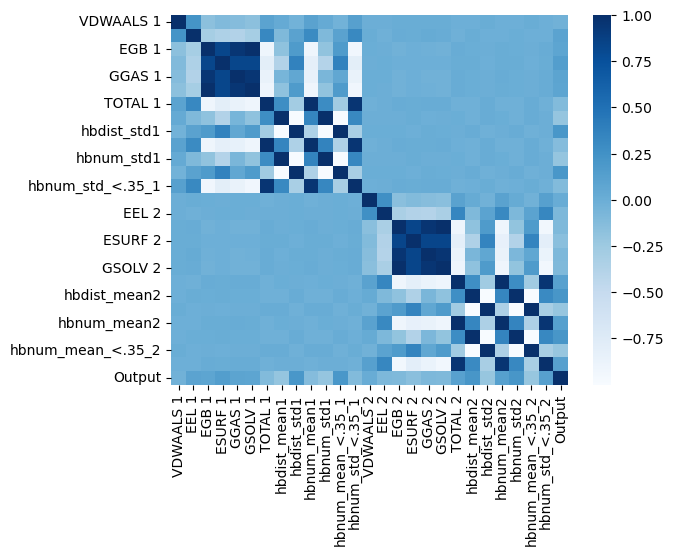

In [19]:
values = training_data.iloc[:,1:]
correlation = values.corr()
fig = plt.figure()
ax = sns.heatmap(correlation, annot=False, cmap = 'Blues')
plt.show()

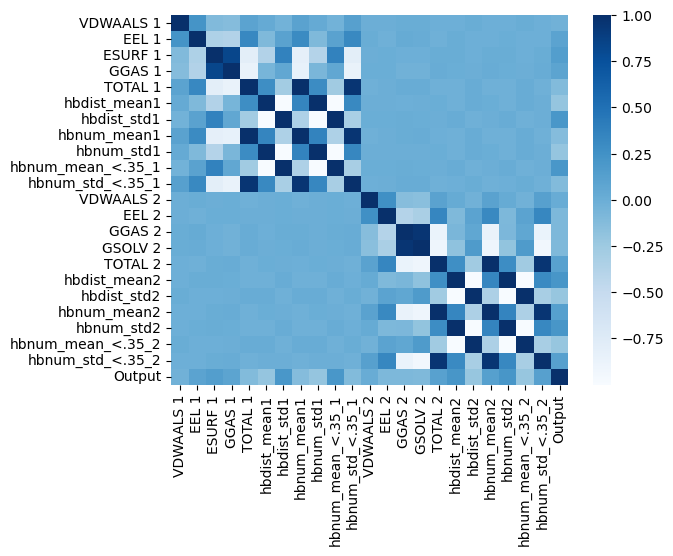

In [64]:
less_feature_correlation = values.iloc[:,[0,1,3,4,6,7,8,9,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26]]
corr = less_feature_correlation.corr()
fig = plt.figure()
ax = sns.heatmap(corr, annot=False, cmap = 'Blues')
plt.show()

In [65]:
scaler = MinMaxScaler()
lesscorrelated_X_train = less_feature_correlation.iloc[:,:-1]
s_lesscorrelated_X_train = scaler.fit_transform(lesscorrelated_X_train)

In [66]:
lesscorr_gnb =  GaussianNB()
cross_val(lesscorr_gnb, s_lesscorrelated_X_train, y_train)

<class 'sklearn.naive_bayes.GaussianNB'>
[0.59946237 0.62264151 0.60916442 0.62264151 0.5606469 ]
mean of cross val score:
0.6029113410428079




In [67]:
lesscorr_cnb = ComplementNB()
cross_val(lesscorr_cnb, s_lesscorrelated_X_train, y_train)

<class 'sklearn.naive_bayes.ComplementNB'>
[0.65591398 0.61725067 0.67654987 0.61994609 0.61185984]
mean of cross val score:
0.6363040894994638




In [68]:
lesscorr_qda = QuadraticDiscriminantAnalysis()
cross_val(lesscorr_qda, s_lesscorrelated_X_train, y_train)

<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
[0.7311828  0.7574124  0.74123989 0.73854447 0.76549865]
mean of cross val score:
0.7467756426977364




In [ ]:
print(np.sum(y_train == 1))
print(np.sum(y_train == 0))

921
935


In [69]:
less_feature_correlation.to_csv("LessCorrelatedFeatures.csv",index=False)